In [1]:
#Import dataset 
train <- read.csv("data/train.csv")
test <- read.csv("data/test.csv")
head(train)
tail(test)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
413,1304,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,,S
414,1305,3,"Spector, Mr. Woolf",male,NA,0,0,A.5. 3236,8.0500,,S
415,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
416,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,,S
417,1308,3,"Ware, Mr. Frederick",male,NA,0,0,359309,8.0500,,S
418,1309,3,"Peter, Master. Michael J",male,NA,1,1,2668,22.3583,,C


In [2]:
# Join together the test and train sets 
test$Survived <- NA
combined_set <- rbind(train, test)

In [3]:
# Convert to a string for split title
combined_set$Name <- as.character(combined_set$Name)

In [4]:
# Engineered variable: Title
# Seperate the title 
combined_set$Title <- sapply(combined_set$Name, FUN=function(x) {strsplit(x, split='[,.]')[[1]][2]})
combined_set$Title <- sub(' ', '', combined_set$Title)

In [5]:
# Marge same type title in groups
combined_set$Title[combined_set$Title %in% c('Mme', 'Mlle')] <- 'Mlle'
combined_set$Title[combined_set$Title %in% c('Capt', 'Don', 'Major', 'Sir')] <- 'Sir'
combined_set$Title[combined_set$Title %in% c('Dona', 'Lady', 'the Countess', 'Jonkheer')] <- 'Lady'

In [6]:
# Convert to a factor
combined_set$Title <- factor(combined_set$Title)

In [7]:
# Mother
combined_set$Mother <- 'Not Mother'
combined_set$Mother[combined_set$Sex == 'female' & combined_set$Parch > 0 & combined_set$Age > 18] <- 'Mother'
combined_set$Mother <- factor(combined_set$Mother)

In [8]:
# Child

combined_set$Child[combined_set$Age < 14] <- 'Child'
combined_set$Child[combined_set$Age >= 14] <- 'Adult'
combined_set$Child <- factor(combined_set$Child)

In [9]:
# Cabin
combined_set$Cabin <- as.character(combined_set$Cabin)
strsplit(combined_set$Cabin[2], NULL)[[1]]
combined_set$Deck<-factor(sapply(combined_set$Cabin, function(x) strsplit(x, NULL)[[1]][1])) 

[1] "C" "8" "5"

In [10]:
# Engineered variable: Family size
combined_set$FamilySize <- combined_set$SibSp + combined_set$Parch + 1

In [12]:
# Engineered variable: Family
combined_set$Surname <- sapply(combined_set$Name, FUN=function(x) {strsplit(x, split='[,.]')[[1]][1]})
combined_set$FamilyID <- paste(as.character(combined_set$FamilySize), combined_set$Surname, sep="")
combined_set$FamilyID[combined_set$FamilySize <= 2] <- 'Small'

In [13]:
# Inspect new feature
table(combined_set$FamilyID)


           11Sage           3Abbott         3Appleton         3Beckwith 
               11                 3                 1                 2 
          3Boulos           3Bourke            3Brown         3Caldwell 
                3                 3                 4                 3 
         3Christy          3Collyer          3Compton          3Cornell 
                2                 3                 3                 1 
          3Coutts           3Crosby           3Danbom           3Davies 
                3                 3                 3                 5 
           3Dodge          3Douglas             3Drew            3Elias 
                3                 1                 3                 3 
      3Frauenthal        3Frolicher 3Frolicher-Stehli        3Goldsmith 
                1                 1                 2                 3 
      3Gustafsson       3Hamalainen           3Hansen             3Hart 
                2                 2               

In [14]:
# Removing all erroneous family IDs
famIDs <- data.frame(table(combined_set$FamilyID))
famIDs <- famIDs[famIDs$Freq <= 2,]
combined_set$FamilyID[combined_set$FamilyID %in% famIDs$Var1] <- 'Small'

In [15]:
# Convert to a factor
combined_set$FamilyID <- factor(combined_set$FamilyID)
combined_set$FamilySizeGroup[combined_set$FamilySize == 1] <- 'single'
combined_set$FamilySizeGroup[combined_set$FamilySize < 5 & combined_set$FamilySize > 1] <- 'Smaller'
combined_set$FamilySizeGroup[combined_set$FamilySize > 4] <- 'large'

In [16]:
# Convert to a factor
combined_set$FamilyID <- factor(combined_set$FamilyID)
combined_set$FamilySizeGroup <- factor(combined_set$FamilySizeGroup)

In [19]:

# Fill in Age NAs
summary(combined_set$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.17   22.00   29.95   29.76   37.00   80.00 

In [21]:
library(rpart)
#Missing value treatment
FillAge <- rpart(Age ~ Pclass + Mother + FamilySize + Sex + SibSp + Parch + Deck + Fare + Embarked + Title + FamilyID + FamilySizeGroup + FamilySize, 
                 data=combined_set[!is.na(combined_set$Age),], method="anova")
combined_set$Age[is.na(combined_set$Age)] <- predict(FillAge, combined_set[is.na(combined_set$Age),])
summary(combined_set)

  PassengerId      Survived          Pclass          Name          
 Min.   :   1   Min.   :0.0000   Min.   :1.000   Length:1309       
 1st Qu.: 328   1st Qu.:0.0000   1st Qu.:2.000   Class :character  
 Median : 655   Median :0.0000   Median :3.000   Mode  :character  
 Mean   : 655   Mean   :0.3838   Mean   :2.295                     
 3rd Qu.: 982   3rd Qu.:1.0000   3rd Qu.:3.000                     
 Max.   :1309   Max.   :1.0000   Max.   :3.000                     
                NA's   :418                                        
     Sex                 Age            SibSp            Parch      
 Length:1309        Min.   : 0.17   Min.   :0.0000   Min.   :0.000  
 Class :character   1st Qu.:22.00   1st Qu.:0.0000   1st Qu.:0.000  
 Mode  :character   Median :29.95   Median :0.0000   Median :0.000  
                    Mean   :29.76   Mean   :0.4989   Mean   :0.385  
                    3rd Qu.:37.00   3rd Qu.:1.0000   3rd Qu.:0.000  
                    Max.   :80.00   Max.  

In [22]:
# Fill in Embarked blanks
summary(combined_set$Embarked)
which(combined_set$Embarked == '')
combined_set$Embarked[c(62,830)] = "S"
combined_set$Embarked <- factor(combined_set$Embarked)

   Length     Class      Mode 
     1309 character character 

[1]  62 830

In [23]:
# Fill in Fare NAs
summary(combined_set$Fare)
which(is.na(combined_set$Fare))
combined_set$Fare[1044] <- median(combined_set$Fare, na.rm=TRUE)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   7.896  14.454  33.295  31.275 512.329       1 

[1] 1044

In [24]:
# New factor for new technique , only allowed <32 levels, so reduce number
combined_set$FamilyID2 <- combined_set$FamilyID

In [25]:
# Convert back to string
combined_set$FamilyID2 <- as.character(combined_set$FamilyID2)
combined_set$FamilyID2[combined_set$FamilySize <= 3] <- 'Small'

In [26]:
# And convert back to factor
combined_set$FamilyID2 <- factor(combined_set$FamilyID2)

In [27]:
#Again Mother
combined_set$Mother <- 'Not Mother'
combined_set$Mother[combined_set$Sex == 'female' & combined_set$Parch > 0 & combined_set$Age > 18] <- 'Mother'
combined_set$Mother <- factor(combined_set$Mother)

In [28]:
#Again Child

combined_set$Child[combined_set$Age < 14] <- 'Child'
combined_set$Child[combined_set$Age >= 14] <- 'Adult'
combined_set$Child <- factor(combined_set$Child)

In [29]:
# Split back into test and train sets
train <- combined_set[1:891,]
test <- combined_set[892:1309,]

In [30]:
# install.packages('randomForest')
library(randomForest)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



In [31]:
set.seed(291)

rftrain01 <- combined_set[1:891,
                          c("Pclass","Age", "Title","Sex","SibSp","Parch","Fare","Embarked","FamilySize","FamilySizeGroup","FamilyID2")]
rflabel <- as.factor(train$Survived)

In [32]:
fit1 <- randomForest(x = rftrain01, y = rflabel, importance = TRUE, ntree = 1000)
fit1


Call:
 randomForest(x = rftrain01, y = rflabel, ntree = 1000, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 3

        OOB estimate of  error rate: 17.17%
Confusion matrix:
    0   1 class.error
0 490  59   0.1074681
1  94 248   0.2748538

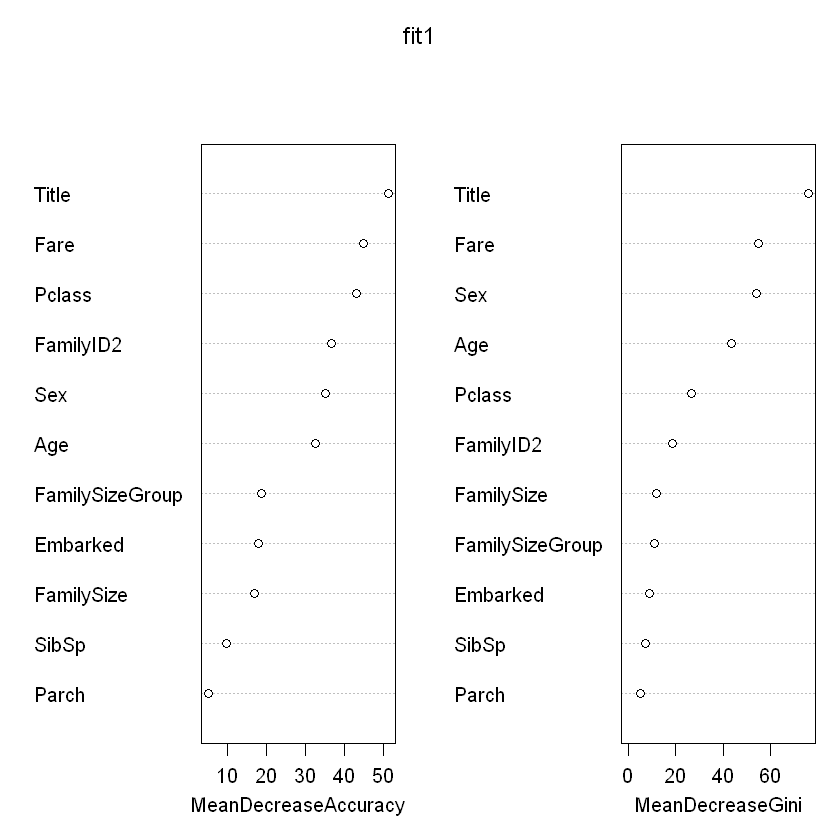

In [33]:
varImpPlot(fit1)

In [36]:
library(sandwich)
library(party)

In [38]:

set.seed(291)
fit2 <- cforest(as.factor(Survived) ~ Pclass +as.factor(Sex) + Age + SibSp + Parch + Fare + Embarked + Title + FamilySize + FamilyID,
                data = train, controls=cforest_unbiased(ntree=2000, mtry=3)) 

In [39]:
# Now make a prediction and write a submission file
MyPredict <- predict(object = fit2, newdata = test, OOB=TRUE, type = "response")

predict7th <- data.frame(PassengerId = test$PassengerId, Survived = MyPredict)
write.csv(predict7th, file = "tree23.csv", row.names = FALSE)